<a href="https://colab.research.google.com/github/raymond234/Identification-of-sub-industry-types-of-Private-Equity-Venture-Capital-deals/blob/main/analysis_02_roberta_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries and Dependencies

In [ ]:
!pip install -U sentence-transformers
!pip install transformers

from transformers import AutoModelForSequenceClassification

from sentence_transformers import SentenceTransformer, losses
from sentence_transformers.readers import InputExample
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers import models, LoggingHandler, util
from torch.utils.data import DataLoader
import logging
import math
from datetime import datetime
import sys
import os
import gzip
import csv

# Model Preparation

In [ ]:
# Code to print out debug information
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])

# Load pre-trained model
model_name = 'roberta-base'

word_embedding_model = models.Transformer(model_name)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
                               pooling_mode_mean_tokens=True,
                               pooling_mode_cls_token=False,
                               pooling_mode_max_tokens=False)
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

model_save_path = '/usr/local/lib/python3.9/dist-packages/models/trained_stsbenchmark_'+model_name.replace("/", "-")+'-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Data Preparation

In [ ]:
# Download Dataset
sts_dataset_path = '/usr/local/lib/python3.9/dist-packages/sbert/stsbenchmark.tsv.gz'

if not os.path.exists(sts_dataset_path):
    util.http_get('https://sbert.net/datasets/stsbenchmark.tsv.gz', sts_dataset_path)

# Read the dataset
train_batch_size = 16
num_epochs = 4

# Convert the dataset to a DataLoader ready for training
logging.info("Read STSbenchmark train dataset")

train_samples = []
dev_samples = []
test_samples = []
with gzip.open(sts_dataset_path, 'rt', encoding='utf8') as fIn:
    reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_NONE)
    for row in reader:
        score = float(row['score']) / 5.0  # Normalize score to range 0 ... 1
        inp_example = InputExample(texts=[row['sentence1'], row['sentence2']], label=score)

        if row['split'] == 'dev':
            dev_samples.append(inp_example)
        elif row['split'] == 'test':
            test_samples.append(inp_example)
        else:
            train_samples.append(inp_example)


train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=train_batch_size)
train_loss = losses.CosineSimilarityLoss(model=model)

logging.info("Read STSbenchmark dev dataset")
evaluator = EmbeddingSimilarityEvaluator.from_input_examples(dev_samples, name='sts-dev')

# Configure and Perform Training and save model

In [ ]:
# Configure the training.
warmup_steps = math.ceil(len(train_dataloader) * num_epochs  * 0.1) #10% of train data for warm-up
logging.info("Warmup-steps: {}".format(warmup_steps))

# Train the model
model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          epochs=num_epochs,
          evaluation_steps=1000,
          warmup_steps=warmup_steps,
          output_path=model_save_path)

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

# Evaluate saved model



In [ ]:
test_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(test_samples, name='sts-test')
test_evaluator(model, output_path=model_save_path)

0.855709868187424

#Conduct Semantic Similarity with the finetuned model

Initializing data cleaning packages

In [ ]:
import itertools
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances

# Load company data into a dataframe



In [ ]:
from google.colab import files
import io
uploaded = files.upload()
df1 = pd.read_excel(io.BytesIO(uploaded['For_emeka_v1.xlsx']), sheet_name="Sheet1")
df1 = df1.loc[:, ["Company", "Product Description"]]

Saving For_emeka_v1.xlsx to For_emeka_v1.xlsx


# Conducting Semantic Similarity with Cosine Similarity and Euclidean Distance as Metrics

Defining the function that will sequentially sort the similarity for every company description (Not too relevant any more)

In [ ]:
def most_similar(doc_id,similarity_matrix, matrix):
    print (f'Document: {df1.iloc[doc_id]["Product Description"]}')
    matchlist = []
    print ('\n')
    print ('Similar Documents:')
    if matrix == 'Cosine Similarity':
        similar_ix = np.argsort(similarity_matrix[doc_id])[::-1][0:11]
    elif matrix =='Euclidean Distance':
        similar_ix = np.argsort(similarity_matrix[doc_id])[0:11]
    for ix in similar_ix:
        if ix == doc_id:
            continue
        print('\n')
        print (f'Document: {df1.iloc[ix]["Product Description"]}')
        print (f'{matrix} : {similarity_matrix[doc_id][ix]}')
        matchlist.append([similarity_matrix[doc_id][ix], df1.iloc[ix]["Company"], df1.iloc[ix]["Product Description"]])
    return matchlist

Repeat the Procedure for the Russell 2000 Dataset

In [ ]:
def most_similar(doc_id,similarity_matrix, matrix):
    print (f'Document: {df1.iloc[doc_id]["Product Description"]}')
    matchlist = []
    print ('\n')
    print ('Similar Documents:')
    if matrix == 'Cosine Similarity':
        similar_ix = np.argsort(similarity_matrix[doc_id])[::-1][0:11]
    elif matrix =='Euclidean Distance':
        similar_ix = np.argsort(similarity_matrix[doc_id])[0:11]
    for ix in similar_ix:
        if ix == doc_id:
            continue
        print('\n')
        print (f'Document: {df1.iloc[ix]["Product Description"]}')
        print (f'{matrix} : {similarity_matrix[doc_id][ix]}')
        matchlist.append([similarity_matrix[doc_id][ix], df1.iloc[ix]["Company"], df1.iloc[ix]["Product Description"]])
    return matchlist

# Loading Model from Memory (Using a finetuned model and loaded from memory to save time and make results reproducible)

In [ ]:
model_path = '/content/drive/MyDrive/trained_stsbenchmark_roberta-base-2023-03-17_11-31-37/trained_stsbenchmark_roberta-base-2023-03-27_22-12-29'
model = SentenceTransformer(model_path)

# Embedding Paragraphs

Conducting semantic similarity with cosine similarity and euclidean distance as parameters

In [ ]:
# Initializing stopwords package
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Intitializing data science packages and NLP packages
import re


# Removing stopwords from company descriptions
stop_words = stopwords.words('english')

df1['cleaned_desc'] = df1["Product Description"].apply(
    lambda x: " ".join(re.sub(r'[^a-zA-Z]',' ',w).lower() for w in str(x).split()
                       if re.sub(r'[^a-zA-Z]',' ',w).lower() not in stop_words))

df1['cleaned_desc'] = df1["cleaned_desc"].apply(
    lambda x: " ".join(re.sub(r'[^a-zA-Z]',' ',w).lower() for w in str(x).split()
                       if re.sub(r'[^a-zA-Z]',' ',w).lower() not in stop_words))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
de1 = model.encode(df1["cleaned_desc"])
ps1 = cosine_similarity(de1)

In [ ]:
document_embeddings = model.encode(df1["Product Description"])

In [ ]:
pairwise_similarities = cosine_similarity(document_embeddings)
pairwise_differences = euclidean_distances(document_embeddings)

In [ ]:
pairwise_similarities

array([[1.0000005 , 0.49294814, 0.51724887, ..., 0.43919066, 0.43253684,
        0.39305195],
       [0.49294814, 1.        , 0.3932265 , ..., 0.21335196, 0.11425257,
        0.16599753],
       [0.51724887, 0.3932265 , 1.0000001 , ..., 0.4052419 , 0.29170677,
        0.5134826 ],
       ...,
       [0.43919066, 0.21335196, 0.4052419 , ..., 0.99999994, 0.37537557,
        0.64840376],
       [0.43253684, 0.11425257, 0.29170677, ..., 0.37537557, 1.        ,
        0.30467236],
       [0.39305195, 0.16599753, 0.5134826 , ..., 0.64840376, 0.30467236,
        1.0000002 ]], dtype=float32)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Convert the similarity matrix to a distance matrix
distance_matrix = 1 - pairwise_similarities

# Apply t-SNE
tsne = TSNE(n_components=2, metric='precomputed', perplexity=30, random_state=42)
projected_points = tsne.fit_transform(distance_matrix)

# Plot the projected points
plt.scatter(projected_points[:, 0], projected_points[:, 1])
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE Projection of Similarity Matrix')
plt.show()


ValueError: ignored

In [ ]:
# Remove the diagonal elements (which are always 1) to avoid skewing the statistics
non_diagonal_indices = np.where(~np.eye(pairwise_similarities.shape[0], dtype=bool))
non_diagonal_values = pairwise_similarities[non_diagonal_indices]

# Calculate summary statistics
mean_similarity = np.mean(non_diagonal_values)
median_similarity = np.median(non_diagonal_values)
min_similarity = np.min(non_diagonal_values)
max_similarity = np.max(non_diagonal_values)
std_similarity = np.std(non_diagonal_values)

print("Mean similarity:", mean_similarity)
print("Median similarity:", median_similarity)
print("Minimum similarity:", min_similarity)
print("Maximum similarity:", max_similarity)
print("Standard deviation:", std_similarity)

Mean similarity: 0.33372235
Median similarity: 0.32893252
Minimum similarity: -0.15912578
Maximum similarity: 1.0
Standard deviation: 0.11950127


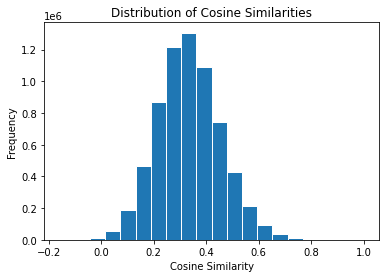

<ipython-input-28-d5abf4c62201>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(non_diagonal_values, shade=True)


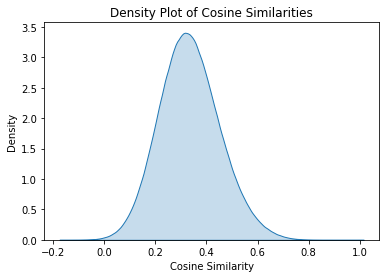

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot a histogram of the cosine similarities
plt.hist(non_diagonal_values, bins=20, edgecolor='black')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Cosine Similarities')
plt.show()

# Plot a kernel density estimation (KDE) of the cosine similarities
sns.kdeplot(non_diagonal_values, shade=True)
plt.xlabel('Cosine Similarity')
plt.ylabel('Density')
plt.title('Density Plot of Cosine Similarities')
plt.show()


In [ ]:
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]

for q in quantiles:
    quantile_value = np.quantile(non_diagonal_values, q)
    print(f"{int(q * 100)}th percentile: {quantile_value}")


10th percentile: 0.25
25th percentile: 0.2515886425971985
50th percentile: 0.328932523727417
75th percentile: 0.41082674264907837
90th percentile: 0.4899265766143799


In [ ]:
import numpy as np
from sklearn.cluster import DBSCAN

# Ensure the minimum value is 0.25 by clipping the matrix


# Convert cosine similarity to distance (1 - similarity)
distance_matrix = 1 - pairwise_similarities
distance_matrix = abs(distance_matrix)
# Apply DBSCAN clustering with a minimum threshold of 0.25 (distance 0.75)
dbscan = DBSCAN(eps=0.25, min_samples=2, metric="precomputed")
clusters = dbscan.fit_predict(distance_matrix)

print("Cluster labels:", clusters)

Cluster labels: [-1 -1 -1 ... 74 -1 -1]


In [ ]:
print(set(clusters))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, -1}


In [ ]:
 sum(element == -1 for element in clusters)

1767

In [ ]:
print(sum(clusters==-1))

25


In [ ]:


distance_matrix = 1 - pairwise_similarities
from sklearn.cluster import AgglomerativeClustering

# Set the desired number of clusters
n_clusters = 94
# Initialize the clustering algorithm with the 'precomputed' affinity
# Note that AgglomerativeClustering expects a distance matrix, not a similarity matrix
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage='average')

# Cluster the data
clusters = agg_clustering.fit_predict(distance_matrix)

print("Cluster labels:", clusters)


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Cluster labels: [14 14 82 ... 11 92 31]


In [ ]:
print(set(clusters))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93}


In [ ]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster
# Perform hierarchical clustering using the 'average' linkage method
distance_matrix = 1 - pairwise_similarities
Z = linkage(distance_matrix, method='average')
# Form clusters by cutting the dendrogram at the specified threshold
clusters = fcluster(Z, t=0, criterion='distance')

print("Cluster labels:", clusters)


Cluster labels: [ 688 1656 1995 ... 2403 1786 2404]


In [ ]:
print(set(clusters))

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

Repeat for the Russell 2000 Dataset

In [ ]:
document_embeddings2 = model.encode(df3["Model Descriptions"])

In [ ]:
pairwise_similarities2 = cosine_similarity(document_embeddings2)
pairwise_differences2 = euclidean_distances(document_embeddings2)

In [ ]:
# Remove the diagonal elements (which are always 1) to avoid skewing the statistics
non_diagonal_indices2 = np.where(~np.eye(pairwise_similarities2.shape[0], dtype=bool))
non_diagonal_values2 = pairwise_similarities2[non_diagonal_indices2]

# Calculate summary statistics
mean_similarity2 = np.mean(non_diagonal_values2)
median_similarity2 = np.median(non_diagonal_values2)
min_similarity2 = np.min(non_diagonal_values2)
max_similarity2 = np.max(non_diagonal_values2)
std_similarity2 = np.std(non_diagonal_values2)

print("Mean similarity:", mean_similarity2)
print("Median similarity:", median_similarity2)
print("Minimum similarity:", min_similarity2)
print("Maximum similarity:", max_similarity2)
print("Standard deviation:", std_similarity2)

Mean similarity: 0.42392886
Median similarity: 0.41286236
Minimum similarity: -0.02178767
Maximum similarity: 0.9897183
Standard deviation: 0.124231465


In [ ]:
import numpy as np
from sklearn.cluster import DBSCAN

# Ensure the minimum value is 0.25 by clipping the matrix


# Convert cosine similarity to distance (1 - similarity)
distance_matrix2 = 1 - pairwise_similarities2
distance_matrix2 = abs(distance_matrix2)
# Apply DBSCAN clustering with a minimum threshold of 0.25 (distance 0.75)
dbscan2 = DBSCAN(eps=0.40, min_samples=2, metric="precomputed")
clusters2 = dbscan2.fit_predict(distance_matrix2)

print("Cluster labels:", clusters2)

Cluster labels: [0 0 0 ... 0 0 0]


In [ ]:
print(set(clusters))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, -1}


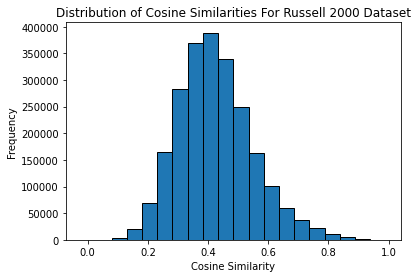

<ipython-input-21-1422a8700e5e>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(non_diagonal_values2, shade=True)


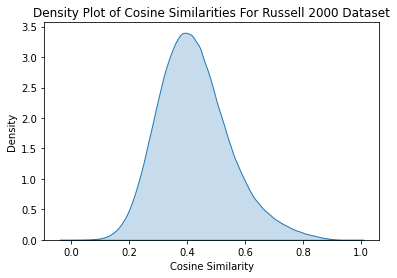

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot a histogram of the cosine similarities
plt.hist(non_diagonal_values2, bins=20, edgecolor='black')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Cosine Similarities For Russell 2000 Dataset')
plt.show()

# Plot a kernel density estimation (KDE) of the cosine similarities
sns.kdeplot(non_diagonal_values2, shade=True)
plt.xlabel('Cosine Similarity')
plt.ylabel('Density')
plt.title('Density Plot of Cosine Similarities For Russell 2000 Dataset')
plt.show()

Scaling functions and results for the entire dataset (Cosine Similarity) (Not too relevant)

In [ ]:
pairwise_similarities2

array([[0.99999994, 0.5227321 , 0.58733845, ..., 0.5832884 , 0.62136066,
        0.4959138 ],
       [0.5227321 , 1.0000004 , 0.49795526, ..., 0.45316336, 0.46851054,
        0.5168105 ],
       [0.58733845, 0.49795526, 1.0000001 , ..., 0.42876464, 0.41302967,
        0.35523286],
       ...,
       [0.5832884 , 0.45316336, 0.42876464, ..., 0.99999964, 0.4989528 ,
        0.46860677],
       [0.62136066, 0.46851054, 0.41302967, ..., 0.4989528 , 1.0000002 ,
        0.44950962],
       [0.4959138 , 0.5168105 , 0.35523286, ..., 0.46860677, 0.44950962,
        0.99999994]], dtype=float32)

In [ ]:
def threek_times_cos():
    temp = []
    for id in range(len(df1.axes[0])):
        temp.append(most_similar(id, pairwise_similarities, 'Cosine Similarity'))
    new_df = pd.DataFrame(temp, columns=["comp_1", "comp_2", "comp_3", "comp_4",
            "comp_5", "comp_6", "comp_7", "comp_8", "comp_9", "comp_10"])
    df = pd.concat([df1, new_df], axis=1)
    return df

df = threek_times_cos()
df


# Write results to an Excel file
!pip install xlsxwriter
df.to_excel("result_cos_dis1.xlsx", index=False, engine="xlsxwriter")

Get Euclidean Distance measures and compare (Not too relevant)

In [ ]:
def threek_times_euc():
    temp = []
    for id in range(len(df1.axes[0])):
        temp.append(most_similar(id, pairwise_differences, 'Euclidean Distance'))
    new_df = pd.DataFrame(temp, columns=["comp_1", "comp_2", "comp_3", "comp_4",
            "comp_5", "comp_6", "comp_7", "comp_8", "comp_9", "comp_10"])
    df2 = pd.concat([df1, new_df], axis=1)
    return df2

df2 = threek_times_euc()
df2

# Write results to an Excel file
df2.to_excel("result_euc1.xlsx", index=False, engine="xlsxwriter")

Repeat Peer Firm Identification for the Russell 2000 dataset

In [ ]:
def threek_times_cos():
    temp = []
    for id in range(len(df1.axes[0])):
        temp.append(most_similar(id, pairwise_similarities, 'Cosine Similarity'))
    new_df = pd.DataFrame(temp, columns=["comp_1", "comp_2", "comp_3", "comp_4",
            "comp_5", "comp_6", "comp_7", "comp_8", "comp_9", "comp_10"])
    df = pd.concat([df1, new_df], axis=1)
    return df

df = threek_times_cos()
df


# Write results to an Excel file
!pip install xlsxwriter
df.to_excel("result_cos_dis1.xlsx", index=False, engine="xlsxwriter")

In [ ]:
def threek_times_euc():
    temp = []
    for id in range(len(df1.axes[0])):
        temp.append(most_similar(id, pairwise_differences, 'Euclidean Distance'))
    new_df = pd.DataFrame(temp, columns=["comp_1", "comp_2", "comp_3", "comp_4",
            "comp_5", "comp_6", "comp_7", "comp_8", "comp_9", "comp_10"])
    df2 = pd.concat([df1, new_df], axis=1)
    return df2

df2 = threek_times_euc()
df2

# Write results to an Excel file
df2.to_excel("result_euc1.xlsx", index=False, engine="xlsxwriter")

# Saving Finetuned Semantic Similarity SBERT Model to disk

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /usr/local/lib/python3.9/dist-packages/models/ /content/drive/MyDrive/trained_stsbenchmark_roberta-base-2023-03-17_11-31-37

##Transitioning to the Next Step of the Analysis. Finetuning Model on the Russell 2000 Industry Classification Dataset

Load Russell 2000 data with Industry Labels

In [ ]:
from google.colab import files
import io
uploaded = files.upload()
df3 = pd.read_excel(io.BytesIO(uploaded['russell_2000_data_students.xlsx']), sheet_name="Clean Data")
df3 = df3.loc[:, ["Name", "Sector", "Model Descriptions"]]
df3

Save Compressed version of the Russell 2000 Dataset

In [ ]:
df3.to_excel('russell_2000_small.xlsx', index=False)

# Data Preprocessing

Balancing unbalanced data

In [ ]:
!pip install datasets
import io
from google.colab import files
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from datasets import DatasetDict, Dataset

uploaded = files.upload()
df3 = pd.read_excel(io.BytesIO(uploaded['russell_2000_small.xlsx']), sheet_name="Sheet1")
df3
# Count number of examples in each category
counts = df3['Sector'].value_counts()

# Set target number of examples per category
target_count = 200

# Resample categories with low counts to have target_count examples
resampled_data = []
for category in counts.index:
    category_data = df3[df3['Sector'] == category]
    if len(category_data) < target_count:
        # Upsample all categories
        category_data = resample(category_data,
                                 replace=True,
                                 n_samples=target_count,
                                 random_state=42)
    else:
        # Downsample if category has more than target_count examples
        category_data = resample(category_data,
                                 replace=False,
                                 n_samples=target_count,
                                 random_state=42)
    resampled_data.append(category_data)

# Combine resampled data and shuffle rows
balanced_df3 = pd.concat(resampled_data).sample(frac=1, random_state=42)

# Save balanced dataset to file
balanced_df3.to_excel('balanced_data.xlsx', index=False)


# Create an instance of LabelEncoder
label_encoder = LabelEncoder()
labels = balanced_df3['Sector'].unique().tolist()

# Fit the label encoder on the categorical labels and transform them to numerical labels
y_numerical = label_encoder.fit_transform(labels)

label_mapping = {}
for idx, label in enumerate(label_encoder.classes_):
    label_mapping[label] = y_numerical[idx]

label_mapping

# Add the numerical labels as a new column in the dataframe
balanced_df3['label'] = balanced_df3['Sector'].map(label_mapping)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 73.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 36.9 MB/s eta 0:00:00


Saving russell_2000_small.xlsx to russell_2000_small.xlsx


Slicing Data into Train/Test/Splits

In [ ]:
# calculate the count of each category in the dataset
balanced_df3 = balanced_df3.loc[:, ["label", "Model Descriptions"]]
category_counts = balanced_df3['label'].value_counts()

# get the minimum category count
min_count = category_counts.min()

# create empty lists for train, validation, and test data
train_data, val_data, test_data = [], [], []

# loop through each category
for category in balanced_df3['label'].unique():

    # subset the data for the current category
    category_data = balanced_df3[balanced_df3['label'] == category]

    # randomly select data to add to train, validation, and test sets
    train, test = train_test_split(category_data, test_size=0.35, random_state=42)
    val, test = train_test_split(test, test_size=0.60, random_state=42)

    # add the data to the appropriate lists
    train_data.append(train)
    val_data.append(val)
    test_data.append(test)

# concatenate the data for each set and shuffle the rows
train_data = pd.concat(train_data).sample(frac=1).reset_index(drop=True)
val_data = pd.concat(val_data).sample(frac=1).reset_index(drop=True)
test_data = pd.concat(test_data).sample(frac=1).reset_index(drop=True)

# create the DatasetDict

dataset_dict = DatasetDict({
    'train': Dataset.from_pandas(train_data),
    'validation': Dataset.from_pandas(val_data),
    'test': Dataset.from_pandas(test_data)
})

# print information about the dataset
for key, dataset in dataset_dict.items():
    print(f"{key}: Dataset({{features: {dataset.features}, num_rows: {len(dataset)}}})")


train: Dataset({features: {'label': Value(dtype='int64', id=None), 'Model Descriptions': Value(dtype='string', id=None)}, num_rows: 1430})
validation: Dataset({features: {'label': Value(dtype='int64', id=None), 'Model Descriptions': Value(dtype='string', id=None)}, num_rows: 308})
test: Dataset({features: {'label': Value(dtype='int64', id=None), 'Model Descriptions': Value(dtype='string', id=None)}, num_rows: 462})


In [ ]:
train_data

,label,Model Descriptions
0,5,an electric and natural gas utility with certa...
1,8,offer a quality postsecondary education prima...
2,0,logistics company that leverages technology an...
3,4,"s a global developer, manufacturer and markete..."
4,7,"a leading, industrial oil and gas products and..."
...,...,...
1425,1,a global content and brand management company...
1426,10,"finances, invests in and develops real estate ..."
1427,5,a diversified land and water resource developm...
1428,4,ne of the nation’s largest family footwear ret...


In [ ]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['label', 'Model Descriptions'],
        num_rows: 1430
    })
    validation: Dataset({
        features: ['label', 'Model Descriptions'],
        num_rows: 308
    })
    test: Dataset({
        features: ['label', 'Model Descriptions'],
        num_rows: 462
    })
})

Creating Paragraph embeddings

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, recall_score, precision_score
import torch
import pandas as pd


# Load the pre-trained transformer tokenizer
model_name = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Define a function to tokenize the descriptions
def tokenize_function(batch):
    return tokenizer(batch["Model Descriptions"], padding=True, truncation=True, max_length=270)

# Apply the encode function to the dataset and generate tokens
russell_encoded = dataset_dict.map(tokenize_function, batched=True, batch_size=32)

# Define the pre-trained Transformer model
num_labels = 11
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# Define the Training Arguments
batch_size = 16
logging_steps = len(russell_encoded["train"])
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=4,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  log_level="error",
                                  optim='adamw_torch'
                                  )

def get_accuracy(preds):
  predictions = preds.predictions.argmax(axis=-1)
  labels = preds.label_ids
  accuracy = accuracy_score(preds.label_ids, preds.predictions.argmax(axis=-1))
  f1_s = f1_score(preds.label_ids, preds.predictions.argmax(axis=-1), average='macro')
  recall = recall_score(preds.label_ids, preds.predictions.argmax(axis=-1), average='macro')
  precision = precision_score(preds.label_ids, preds.predictions.argmax(axis=-1), average='macro')
  return {'accuracy': accuracy, 'f1_score' : f1_s, 'recall_score' : recall, 'precision_score' : precision}





Map:   0%|          | 0/1430 [00:00<?, ? examples/s]

Map:   0%|          | 0/308 [00:00<?, ? examples/s]

Map:   0%|          | 0/462 [00:00<?, ? examples/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [ ]:
def get_accuracy(preds):
  predictions = preds.predictions.argmax(axis=-1)
  labels = preds.label_ids
  accuracy = accuracy_score(preds.label_ids, preds.predictions.argmax(axis=-1))
  f1_s = f1_score(preds.label_ids, preds.predictions.argmax(axis=-1), average='macro')
  recall = recall_score(preds.label_ids, preds.predictions.argmax(axis=-1), average='macro')
  precision = precision_score(preds.label_ids, preds.predictions.argmax(axis=-1), average='macro')
  return {'accuracy': accuracy, 'f1_score' : f1_s, 'recall_score' : recall, 'precision_score' : precision}


# Train the Model

In [ ]:
# Define the Trainer object
trainer = Trainer(
    model=model,
    compute_metrics=get_accuracy,
    args=training_args,
    train_dataset=russell_encoded["train"],
    eval_dataset=russell_encoded["validation"],
    tokenizer=tokenizer,
)

# Fine-tune the model
trainer.train();

# Evaluate the fine-tuned model on the validation set
result = trainer.evaluate()

# Print the evaluation metrics
print(result)
print(model.config.num_labels)

Epoch,Training Loss,Validation Loss,Accuracy,F1 Score,Recall Score,Precision Score
1,No log,0.276153,0.902597,0.902414,0.902597,0.907821
2,No log,0.269780,0.941558,0.940281,0.941558,0.944245
3,No log,0.266349,0.938312,0.937269,0.938312,0.941144
4,No log,0.244438,0.948052,0.947075,0.948052,0.948835


{'eval_loss': 0.2444380223751068, 'eval_accuracy': 0.948051948051948, 'eval_f1_score': 0.9470754844886247, 'eval_recall_score': 0.9480519480519479, 'eval_precision_score': 0.9488346735723048, 'eval_runtime': 0.8849, 'eval_samples_per_second': 348.057, 'eval_steps_per_second': 22.601, 'epoch': 4.0}
11


In [ ]:
preds = trainer.predict(russell_encoded['test'])
preds
accuracy_score(preds.label_ids, preds.predictions.argmax(axis=-1))

0.9632034632034632

In [ ]:
f1_score(preds.label_ids, preds.predictions.argmax(axis=-1), average='macro')

0.9626142442851637

In [ ]:
recall_score(preds.label_ids, preds.predictions.argmax(axis=-1), average='macro')

0.9632034632034632

In [ ]:
precision_score(preds.label_ids, preds.predictions.argmax(axis=-1), average='macro')

0.9634319031557123

# Saving Finetuned Classification Model to Disk

In [ ]:
model_save_path = '/usr/local/lib/python3.9/dist-packages/models/trained_russell_2000_'+model_name.replace("/", "-")+'-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

!cp -r /usr/local/lib/python3.9/dist-packages/models/ /content/drive/MyDrive/trained_russell_2000_roberta-base-2023-03-17_12-37-33

# Classify companies in the dataset according to their subindustry

In [ ]:
label_mapping

{'Basic Materials': 3,
 'Communication Services': 1,
 'Consumer Cyclical': 4,
 'Consumer Defensive': 8,
 'Energy': 7,
 'Financial Services': 2,
 'Healthcare': 9,
 'Industrials': 0,
 'Real Estate': 10,
 'Technology': 6,
 'Utilities': 5}

## Loading Topic Classification Model from Memory

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch
import pandas as pd

model_from_disk = "/content/drive/MyDrive/trained_russell_2000_distilbert-base-uncased-2023-03-17_12-37-33/trained_russell_2000_distilbert-base-uncased-2023-03-17_12-37-33"

model = AutoModelForSequenceClassification.from_pretrained(model_from_disk)
tokenizer = AutoTokenizer.from_pretrained(model_from_disk)

OSError: ignored

# Reinitializations of needed variables for "Model from Disk"

In [ ]:
# Define a function to tokenize the descriptions
def tokenize_function(batch):
    return tokenizer(batch["Model Descriptions"], padding=True, truncation=True, max_length=270)

# Apply the encode function to the dataset and generate tokens
russell_encoded = dataset_dict.map(tokenize_function, batched=True, batch_size=32)


Map:   0%|          | 0/1430 [00:00<?, ? examples/s]

Map:   0%|          | 0/308 [00:00<?, ? examples/s]

Map:   0%|          | 0/462 [00:00<?, ? examples/s]

In [ ]:
model.config.num_labels

11

Classifying Sample according to Russell 2000 industry classifications

In [ ]:
from transformers import pipeline

# initialize the classifier pipeline
model.to("cpu")
classifier = pipeline('text-classification', model=model, tokenizer=tokenizer, top_k=3)

# classify the text and extract top 3 predictions for each row
new_df = df1['Product Description'].apply(lambda x: [[p['label'], round(p['score'], 4)] for p in sorted(classifier(x)[0], key=lambda p: p['score'], reverse=True)[:3]])
new_df = pd.DataFrame(new_df.tolist(), columns=["First", "Second", "Third"])
df1 = pd.concat([df1, new_df], axis=1)
df1 = df1.iloc[:, :5]



#df1.to_excel("result_txt_cls.xlsx", index=False, engine="xlsxwriter")


In [ ]:
df1

,Company,Product Description,First,Second,Third
0,Sabre,Sabre Corporation is a U.S.-based travel techn...,"[LABEL_6, 0.5692]","[LABEL_1, 0.2094]","[LABEL_0, 0.0586]"
1,SABRELINER CORPATION,Sabreliner Aviation is a highly capable aircra...,"[LABEL_0, 0.5569]","[LABEL_4, 0.175]","[LABEL_10, 0.0393]"
2,Sabroe Refrigeration,"Sabroe Refrigeration, a manufacturer of indust...","[LABEL_0, 0.5322]","[LABEL_3, 0.2386]","[LABEL_4, 0.0561]"
3,Saeco,"Saeco International Group designs, produces, a...","[LABEL_4, 0.4348]","[LABEL_8, 0.3505]","[LABEL_0, 0.0702]"
4,Safe Traffic,RoadSafe Traffic Systems is a provider of traf...,"[LABEL_0, 0.7203]","[LABEL_4, 0.0792]","[LABEL_3, 0.0441]"
...,...,...,...,...,...
2590,Zumiez Inc.,Zumiez Inc is a United-States-based specialty ...,"[LABEL_4, 0.7746]","[LABEL_8, 0.0699]","[LABEL_0, 0.0373]"
2591,ZVC Group Limited,Zenith Vehicle Contracts is a provider of flee...,"[LABEL_0, 0.3912]","[LABEL_4, 0.3835]","[LABEL_10, 0.0419]"
2592,ZymoGenetics,Researcher and developer of therapeutic protei...,"[LABEL_9, 0.8823]","[LABEL_6, 0.0185]","[LABEL_3, 0.0148]"
2593,Zynga,Zynga is a mobile game developer that creates ...,"[LABEL_6, 0.3131]","[LABEL_1, 0.2667]","[LABEL_4, 0.1345]"


Creating extra columns from the classification column for hierarchical clustering and correlation analysis

In [ ]:

# Getting the integer tags of the industry labels for use in comparison of hierarchical clustering and
# Validated clustering
df1['First1'] = df1['First'].apply(lambda x: int(x[0][6:]))

# Getting the confidence scores/probabilities of the Russell 2000 labelling for use in correlation
df1['First2'] = df1['First'].apply(lambda x: float(x[1]))

# Carrying out Hierarchical Clustering with the Cosine Similarity Matrix

In [ ]:
from scipy.cluster.hierarchy import ward, fcluster, dendrogram
from sklearn.metrics import adjusted_mutual_info_score, silhouette_score

# Apply Ward's method to the pairwise similarity matrix
linkage_matrix = ward(pairwise_similarities)

# Cluster the data using the top num_clusters labels as the threshold
clusters = fcluster(linkage_matrix, t=12, criterion='distance')

# Add a column with the cluster assignments to the original data frame
df1['cluster'] = clusters


In [ ]:
# Calculate the adjusted mutual information
ami_score = adjusted_mutual_info_score(df1["First1"], clusters)

print("Adjusted mutual information score:", ami_score)

In [ ]:
opt_clusters = len(df1["cluster"].unique())

In [ ]:
opt_clusters

85

In [ ]:
from scipy.cluster.hierarchy import ward, fcluster, dendrogram
from sklearn.metrics import adjusted_mutual_info_score, silhouette_score

# Apply Ward's method to the pairwise similarity matrix
linkage_matrix = ward(pairwise_similarities)

# Set the range of possible cluster numbers
min_clusters = 10
max_clusters = 120

# Loop through the range and get cluster labels
cluster_labels_list = []
for n_clusters in range(min_clusters, max_clusters + 1):
    cluster_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
    cluster_labels_list.append(cluster_labels)

from sklearn.metrics import silhouette_score

silhouette_scores = []
for cluster_labels in cluster_labels_list:
    score = silhouette_score(pairwise_similarities, cluster_labels, metric='euclidean')
    silhouette_scores.append(score)



In [ ]:
import numpy as np

optimal_clusters = np.argmax(silhouette_scores) + min_clusters
print(f"Optimal number of clusters: {optimal_clusters}")

Optimal number of clusters: 10


Repeat Hierarchical Clustering for the Russell 2000 dataset

In [ ]:
from scipy.cluster.hierarchy import ward, fcluster, dendrogram
from sklearn.metrics import adjusted_mutual_info_score, silhouette_score

# Apply Ward's method to the pairwise similarity matrix
linkage_matrix = ward(pairwise_similarities, metric="cosine")

# Cluster the data using the top num_clusters labels as the threshold
clusters = fcluster(linkage_matrix, t=12, criterion='distance')

# Add a column with the cluster assignments to the original data frame
df1['cluster'] = clusters
# Calculate the adjusted mutual information
#ami_score = adjusted_mutual_info_score(df1["First1"], clusters)

#print("Adjusted mutual information score:", ami_score)

In [ ]:
opt_clusters = len(df1["cluster"].unique())

In [ ]:
opt_clusters

# Validating the clustering results

In [ ]:
silhouette_scores = []

for k in range(0, 20):
    labels = fcluster(linkage_matrix, k, criterion='distance')
    silhouette_scores.append(silhouette_score(pairwise_similarities, labels))

# Print the silhouette score for each number of clusters
for k, score in enumerate(silhouette_scores):
    print(f"Silhouette score for a t of {k}: {score}")

Silhouette score for a t of 0: 0.0030828516464680433
Silhouette score for a t of 1: 0.007113335654139519
Silhouette score for a t of 2: 0.010342516005039215
Silhouette score for a t of 3: 0.060726597905159
Silhouette score for a t of 4: 0.09866802394390106
Silhouette score for a t of 5: 0.08872194588184357
Silhouette score for a t of 6: 0.0752784013748169
Silhouette score for a t of 7: 0.0652662068605423
Silhouette score for a t of 8: 0.05982930585741997
Silhouette score for a t of 9: 0.057430099695920944
Silhouette score for a t of 10: 0.053234364837408066
Silhouette score for a t of 11: 0.049743182957172394
Silhouette score for a t of 12: 0.051222220063209534
Silhouette score for a t of 13: 0.05033256113529205
Silhouette score for a t of 14: 0.050537433475255966
Silhouette score for a t of 15: 0.04936263710260391
Silhouette score for a t of 16: 0.04966846853494644
Silhouette score for a t of 17: 0.04616357758641243
Silhouette score for a t of 18: 0.04519606754183769
Silhouette score 

# Viewing the dendrograms in order to assign t

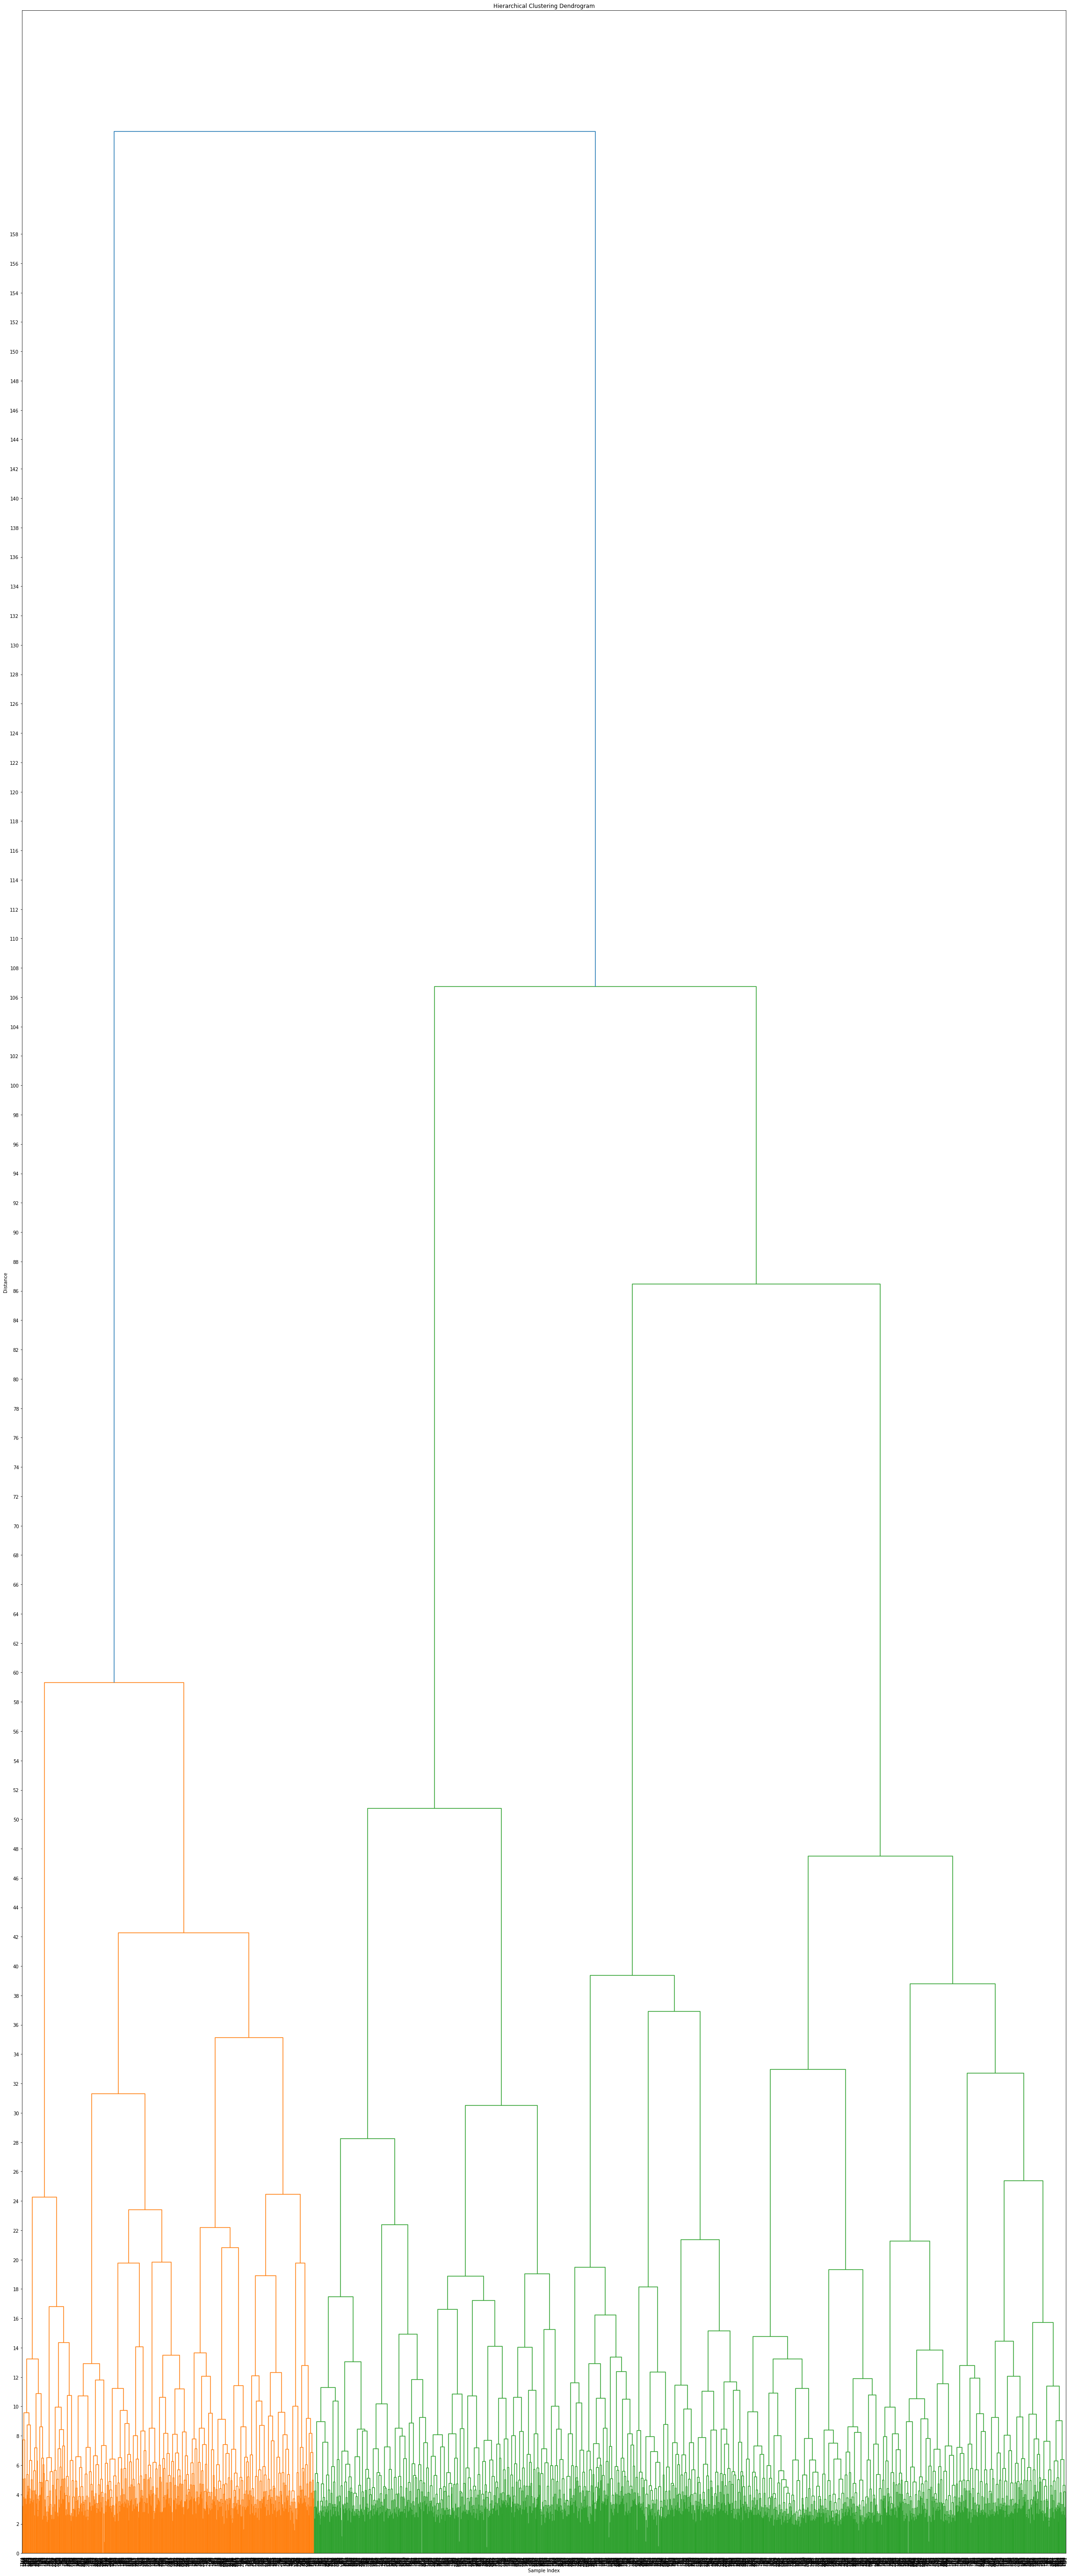

In [ ]:
import matplotlib.pyplot as plt

# Plot the dendrogram
plt.figure(figsize=(40, 100))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.ylim([0, 25])
dendrogram(linkage_matrix, leaf_rotation=90., leaf_font_size=8., show_contracted=True)
# Set tick marks every 2 points
plt.yticks(np.arange(0, 160, 2))
plt.show()


# Checking the Relationship between Word Counts in my Paragraphs and Confidence Scores from the Topic Classification Task

In [ ]:
def count_words(text):
    return len(text.split())

# apply function to 'text' column and create new column with word count
df1['word_count'] = df1['Product Description'].apply(count_words)




In [ ]:
from scipy.stats import pearsonr
df1
corr = pearsonr(df1["First"], df1["word_count"])
corr

PearsonRResult(statistic=0.02264593047865715, pvalue=0.248827631256814)

# Excursus: Perform Hypertuning

In [ ]:
!pip install optuna
import torch.optim

import optuna


# Define a search space for hyperparameters
def objective(trial):
    train_batch_size = trial.suggest_categorical("Batch", [8, 16, 32, 64])
    train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=train_batch_size)
    num_epochs = trial.suggest_int("num_epochs", 3, 10)
    lr = trial.suggest_float('lr', 0.00002, 0.01, log=True)
    weight_decay = trial.suggest_float('weight_decay', 0.0, 0.1)
    warmup_steps = math.ceil(len(train_dataloader) * num_epochs  * 0.1)

    # Define the logging handler
    logging_handler = logging.StreamHandler()
    logger = logging.getLogger()
    logger.addHandler(logging_handler)
    logger.setLevel(logging.INFO)

    # Train the model
    model.fit(train_objectives=[(train_dataloader, train_loss)],
              epochs=num_epochs,
              evaluator=evaluator,
              optimizer_params={'lr':lr, 'weight_decay':weight_decay},
              evaluation_steps=1000,
              warmup_steps=warmup_steps,
              output_path=model_save_path,
              save_best_model=True)

    # Evaluate the model
    score = evaluator(model)

    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best hyperparameters and score
print("Best hyperparameters: ", study.best_params)
print("Best score: ", study.best_value)

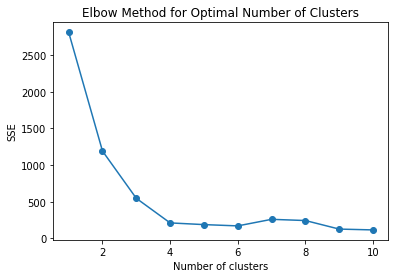

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import SpectralClustering
from sklearn.metrics import pairwise_distances

# Generate sample data
data, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.6, random_state=0)

# Calculate the similarity matrix
similarity_matrix = np.exp(-pairwise_distances(data, metric='euclidean')**2 / (2. * 0.6**2))

# Initialize variables
sse = []
max_clusters = 10

# Iterate through possible cluster numbers
for n_clusters in range(1, max_clusters+1):
    # Perform spectral clustering with n_clusters
    clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=0).fit(similarity_matrix)
    labels = clustering.labels_

    # Calculate the sum of squared errors (SSE)
    cluster_centers = np.array([data[labels == i].mean(axis=0) for i in range(n_clusters)])
    sse.append(np.sum([np.sum((data[labels == i] - cluster_centers[i])**2) for i in range(n_clusters)]))

# Plot the SSE as a function of the number of clusters
plt.plot(range(1, max_clusters+1), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()


In [ ]:
# Initialize variables
sse = []
max_clusters = 120

# Iterate through possible cluster numbers
for n_clusters in range(1, max_clusters+1):
    # Perform spectral clustering with n_clusters
    clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', assign_labels='discretize', random_state=0)
    labels = clustering.fit_predict(1 - pairwise_similarities)

    # Calculate the sum of squared errors (SSE)
    cluster_centers = np.array([pairwise_similarities[labels == i].mean(axis=0) for i in range(n_clusters)])
    sse.append(np.sum([np.sum((pairwise_similarities[labels == i] - cluster_centers[i])**2) for i in range(n_clusters)]))

# Plot the SSE as a function of the number of clusters
plt.plot(range(1, max_clusters+1), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_spectral_embedding.py:393: UserWarning: Exited at iteration 29 with accuracies 
[8.53220799e-16 4.31978349e-05 3.69908942e-05]
not reaching the requested tolerance 3.866851329803467e-05.
Use iteration 29 instead with accuracy 
2.6729576381911184e-05.

  _, diffusion_map = lobpcg(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_spectral_embedding.py:393: UserWarning: Exited postprocessing with accuracies 
[8.91020675e-16 4.31978350e-05 3.69908941e-05]
not reaching the requested tolerance 3.866851329803467e-05.
  _, diffusion_map = lobpcg(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_spectral_embedding.py:393: UserWarning: Exited at iteration 24 with accuracies 
[7.41480440e-16 2.63814604e-05 3.83823299e-05 3.40215918e-05
 4.57938818e-05 3.47925918e-05]
not reaching the requested tolerance 3.866851329803467e-05.
Use iteration 24 instead with accuracy 
2.9895309295018058e-05.

  _, diffusion_map = lobpcg(
/usr/l

KeyboardInterrupt: ignored

In [ ]:
data, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.6, random_state=0)

data, _

(array([[ 8.36856841e-01,  2.13635938e+00],
        [-1.41365810e+00,  7.40962324e+00],
        [ 1.15521298e+00,  5.09961887e+00],
        [-1.01861632e+00,  7.81491465e+00],
        [ 1.27135141e+00,  1.89254207e+00],
        [ 3.43761754e+00,  2.61654166e-01],
        [-1.80822253e+00,  1.59701749e+00],
        [ 1.41372442e+00,  4.38117707e+00],
        [-2.04932168e-01,  8.43209665e+00],
        [-7.11099611e-01,  8.66043846e+00],
        [-1.71237268e+00,  2.77780226e+00],
        [-2.67000792e+00,  8.35389140e+00],
        [ 1.24258802e+00,  4.50399192e+00],
        [-2.22783649e+00,  6.89479938e+00],
        [ 1.45513831e+00, -2.91989981e-02],
        [ 4.53791789e-01,  3.95647753e+00],
        [ 1.06923853e+00,  4.53068484e+00],
        [ 2.56936589e+00,  5.07048304e-01],
        [-1.06690610e+00,  3.13165795e+00],
        [-1.07859101e+00,  2.20451529e+00],
        [ 2.71506328e+00,  1.29082190e+00],
        [ 1.77710994e+00,  1.18655254e+00],
        [ 7.34363910e-01,  5.037

In [ ]:
st

In [ ]:
document_embeddings

array([[ 0.0830702 ,  0.4550262 ,  0.30175155, ..., -0.32805318,
         0.38000143,  0.27477527],
       [ 0.36227927,  0.48169208, -0.14950725, ...,  0.27996984,
         0.29217136,  0.7336328 ],
       [-0.05123498, -0.08327104, -0.881902  , ..., -0.37111238,
         0.07557292,  0.465393  ],
       ...,
       [ 0.19504994, -0.38155803, -0.92140126, ..., -0.3567492 ,
         0.42861065, -0.0303007 ],
       [-0.09709626,  0.02800481, -0.17427634, ..., -0.82495093,
         0.56398326, -0.40782976],
       [ 0.05372253, -0.6033732 , -0.92441726, ..., -0.6160772 ,
         1.043764  ,  0.07124043]], dtype=float32)